In [1]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import functools
import itertools
import sympy
from tqdm.notebook import trange,tqdm
import copy
import pickle
from IPython.display import display,clear_output
from random import choice
import os

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.decomposition import PCA, SparsePCA
from torch.autograd import grad
from scipy.optimize import minimize as scipy_min
from scipy.spatial import ConvexHull
from scipy.optimize import minimize, Bounds, linprog
from sympy import lambdify
from sympy import Symbol as sb
from error_injection import MissingValueError, SamplingError, Injector
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, auc, roc_curve, roc_auc_score, f1_score
np.random.seed(1)

class style():
    RED = '\033[31m'
    GREEN = '\033[32m'
    BLUE = '\033[34m'
    RESET = '\033[0m'

In [2]:
from ucimlrepo import fetch_ucirepo 
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
# metadata 
print(auto_mpg.metadata) 
  
# variable information 
print(auto_mpg.variables) 

{'uci_id': 9, 'name': 'Auto MPG', 'repository_url': 'https://archive.ics.uci.edu/dataset/9/auto+mpg', 'data_url': 'https://archive.ics.uci.edu/static/public/9/data.csv', 'abstract': 'Revised from CMU StatLib library, data concerns city-cycle fuel consumption', 'area': 'Other', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 398, 'num_features': 7, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': [], 'target_col': ['mpg'], 'index_col': ['car_name'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1993, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5859H', 'creators': ['R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for th

In [3]:
X[X.horsepower.isna()]

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
32,98.0,4,NaN,2046,19.0,71,1
126,200.0,6,NaN,2875,17.0,74,1
330,85.0,4,NaN,1835,17.3,80,2
336,140.0,4,NaN,2905,14.3,80,1
354,100.0,4,NaN,2320,15.8,81,2
374,151.0,4,NaN,3035,20.5,82,1


In [4]:
print(f'missing value: {np.sum(X.horsepower.isna())} out of {len(X)} ({np.sum(X.horsepower.isna())/len(X)*100}%)')

missing value: 6 out of 398 (1.507537688442211%)


In [5]:
X_pd, y_pd = X.copy(), y.copy()

# Convert the data to symbols

In [6]:
X = X.to_numpy()
y = y.to_numpy().ravel()
X_extended = np.append(np.ones((len(X), 1)), X, axis=1)
ss = StandardScaler()
X_extended[:, 1:] = ss.fit_transform(X_extended[:, 1:])

In [7]:
imputers = [KNNImputer(n_neighbors=5), KNNImputer(n_neighbors=10), KNNImputer(n_neighbors=15),
            IterativeImputer()]
# missing horsepower in some rows
uncertain_attr = 3
num_attrs = X_extended.shape[1]
X_nan = X_extended.copy()
imputed_cols = []
imputed_datasets = []
for imp in imputers:
    imputed_dataset = imp.fit_transform(X_nan)
    imputed_datasets.append(imputed_dataset)
    imputed_cols.append(imputed_dataset[:, uncertain_attr])

X_extended_max = X_extended.copy()
X_extended_max[:, uncertain_attr] = np.max(imputed_cols, axis=0)
X_extended_min = X_extended.copy()
X_extended_min[:, uncertain_attr] = np.min(imputed_cols, axis=0)

In [8]:
symbol_id = -1
def create_symbol(suffix=''):
    global symbol_id
    symbol_id += 1
    name = f'e{symbol_id}_{suffix}' if suffix else f'e{symbol_id}'
    return sympy.Symbol(name=name)

In [9]:
# # merge high order errors and keep the constant and linear terms
# def merge_high_order_components_old(expr):
#     if not(isinstance(expr, sympy.Expr)):
#         assert isinstance(expr, int) or isinstance(expr, float)
#         return expr
    
#     coef_high_order = 0
#     processed_expr = 0
    
#     if len(expr.args) == 0:
#         return expr
    
#     expr = expr.expand()
#     for arg in expr.args:
#         if arg.free_symbols and (sum(arg.as_poly().monoms()[0]) > 1):
#             coef_high_order += abs(arg.args[0])
#         else:
#             processed_expr += arg
    
#     if coef_high_order > 0:
#         processed_expr += coef_high_order * create_symbol()
        
#     return processed_expr

# def merge_independent_terms_old(expr_ls, initial_common_symbols=set()):
#     # get a set of shared symbols
#     common_symbols = copy.deepcopy(initial_common_symbols)
#     for expr in expr_ls:
#         if not(isinstance(expr, sympy.Expr)):
#             assert isinstance(expr, int) or isinstance(expr, float)
#         else:
#             if common_symbols:
#                 common_symbols = common_symbols.intersection(expr.free_symbols)
#             else:
#                 common_symbols = expr.free_symbols
    
#     # prune each expression by merging independent terms (not shared with other expressions)
#     # assume only linear and constant terms in the expression
#     # replace each expression in the list with corresponding pruned version
#     for expr_id, expr in enumerate(expr_ls):
#         if len(expr.args) == 0:
#             continue
#         expr = expr.expand()
#         processed_expr = 0
#         merged_coef = 0
#         # go through each linear/constant term
#         for arg in expr.args:
#             if arg.free_symbols:
#                 pair = arg.args
#                 # if pair is empty, then coef=1
#                 if pair:
#                     coef, err_symbol = pair[0], pair[1]
#                 else:
#                     coef, err_symbol = 1, arg
#                 # keep if symbol is shared, otherwise merge
#                 if err_symbol in common_symbols:
#                     processed_expr += arg
#                 else:
#                     merged_coef += abs(coef)
#             else:
#                 processed_expr += arg
#         if merged_coef > 0:
#             processed_expr += merged_coef * create_symbol()
#         expr_ls[expr_id] = processed_expr
    
#     return expr_ls


# # prune components with small coefs
# # the components with coef less than pruning_ratio * maximum_coef will be merged together
# # budget is the maximum number of terms that can be kept in each dimension
# def merge_small_components_old(expr, pruning_ratio=1e3, budget=10):
#     if not(isinstance(expr, sympy.Expr)):
#         assert isinstance(expr, int) or isinstance(expr, float)
#         return expr
    
#     processed_expr_ls_new = []
#     processed_expr_ls_orig = []
#     processed_expr = 0
#     max_coef = 0
#     merged_coef = 0
    
#     if len(expr.args) == 0:
#         return expr
    
#     expr = expr.expand()
#     for arg in expr.args:
#         if arg.free_symbols:
#             pair = arg.args
#             # if pair is empty, then coef = 1
#             if pair:
#                 coef, err_symbol = pair[0], pair[1]
#             else:
#                 coef, err_symbol = 1, arg
#             if abs(coef) > max_coef:
#                 max_coef = abs(coef)
#             if err_symbol in symbols_in_data:
#                 processed_expr_ls_orig += [(coef, err_symbol)]
#             else:
#                 processed_expr_ls_new += [(coef, err_symbol)]
#         else:
#             max_coef = max(max_coef, abs(arg))
#             processed_expr += arg

    
#     # merge based on budget, do not merge original symbol
#     if len(processed_expr_ls_new) + len(processed_expr_ls_orig) > budget:
#         processed_expr_ls = sorted(processed_expr_ls_new + processed_expr_ls_orig, 
#                                    key=lambda p: abs(p[0]))
#         merged_terms = processed_expr_ls[:-budget]
#         processed_expr_ls = processed_expr_ls[-budget:]
#         merged_coef += sum([abs(p[0]) for p in merged_terms])
#     else:
#         processed_expr_ls = processed_expr_ls_new + processed_expr_ls_orig
    
#     for coef, err_symbol in processed_expr_ls:
#         if abs(coef) > (max_coef / pruning_ratio):
#             processed_expr += coef * err_symbol
#         else:
#             merged_coef += abs(coef)
    
#     processed_expr += merged_coef * create_symbol()
    
#     return processed_expr


# def merge_small_components_old_old(expr, pruning_ratio=1e3):
#     if not(isinstance(expr, sympy.Expr)):
#         assert isinstance(expr, int) or isinstance(expr, float)
#         return expr
    
#     processed_expr_ls = []
#     processed_expr = 0
#     max_coef = 0
#     merged_coef = 0
    
#     if len(expr.args) == 0:
#         return expr
    
#     expr = expr.expand()
#     for arg in expr.args:
#         if arg.free_symbols:
#             pair = arg.args
#             # if pair is empty, then coef=1
#             if pair:
#                 coef, err_symbol = pair[0], pair[1]
#             else:
#                 coef, err_symbol = 1, arg
#             if abs(coef) > max_coef:
#                 max_coef = abs(coef)
#             processed_expr_ls += [(coef, err_symbol)]
#         else:
#             processed_expr += arg
            
#     for coef, err_symbol in processed_expr_ls:
#         if abs(coef) > (max_coef / pruning_ratio):
#             processed_expr += coef * err_symbol
#         else:
#             merged_coef += abs(coef)
#     if merged_coef > 0:
#         processed_expr += merged_coef * create_symbol()
#     return processed_expr


##################################################################################################
# affine form to interval
def to_interval(expr):
    if not(isinstance(expr, sympy.Expr)):
        assert isinstance(expr, int) or isinstance(expr, float)
        return expr
        
    const_sum = 0
    coef_sum = 0
    
    if len(expr.args) == 0:
        return expr

    expr = expr.expand()
    for arg in expr.args:
        if arg.free_symbols:
            pair = arg.args
            # if pair is empty, then coef=1
            if pair:
                coef = pair[0]
            else:
                coef = 1
            coef_sum += abs(coef)
        else:
            const_sum += arg
        
    return [const_sum-coef_sum,const_sum+coef_sum]


linearization_dict = dict()
reverse_linearization_dict = dict()
# merge high order errors and keep the constant and linear terms
def merge_high_order_components(expr_ls):
    processed_expr_ls = [0 for _ in range(len(expr_ls))]
    for expr_id, expr in enumerate(expr_ls):
        # Do not support monomial expr currently, e.g., expr = 1.5*e1. 
        # At lease two monomials in expr, e.g., expr = 1.5*e1 + 2.
        if not(expr.free_symbols):
            processed_expr_ls[expr_id] += expr
            continue
        expr = expr.expand()
        for arg in expr.args:
            if not(arg.free_symbols):
                processed_expr_ls[expr_id] += arg
                continue
            p = arg.as_poly()
            monomial_exponents = p.monoms()[0]
            
            # only deal with non-linear monomials (order > 2)
            if sum(monomial_exponents) <= 1:
                processed_expr_ls[expr_id] += arg
                continue

            monomial = sympy.prod(x**k for x, k in zip(p.gens, monomial_exponents))
            # check global substitution dictionary
            if monomial in linearization_dict:
                processed_expr_ls[expr_id] += arg.coeff(monomial)*linearization_dict[monomial]
            else:
                found = False
                subs_monomial = create_symbol()
                for symb in monomial.free_symbols:
                    if symb in reverse_linearization_dict:
                        equivalent_monomial = monomial.subs(symb, reverse_linearization_dict[symb])
                        if equivalent_monomial in linearization_dict:
                            subs_monomial = linearization_dict[equivalent_monomial]
                            found = True
                            break
                linearization_dict[monomial] = subs_monomial
                if not(found):
                    reverse_linearization_dict[subs_monomial] = monomial
                processed_expr_ls[expr_id] += arg.coeff(monomial)*subs_monomial
                
    return processed_expr_ls


# take a list of expressions as input, output the list of monomials and generator vectors,
def get_generators(expr_ls):
    monomials = dict()
    for expr_id, expr in enumerate(expr_ls):
        if not(isinstance(expr, sympy.Expr)) or not(expr.free_symbols):
            continue
        expr = expr.expand()
        p = sympy.Poly(expr)
        monomials_in_expr = [sympy.prod(x**k for x, k in zip(p.gens, mon)) 
                             for mon in p.monoms() if sum(mon) >= 1]
        for monomial in monomials_in_expr:
            coef = float(p.coeff_monomial(monomial))
            if monomial in monomials:
                if len(monomials[monomial]) < expr_id:
                    monomials[monomial] = monomials[monomial] + [0 for _ in range(expr_id-len(monomials[monomial]))]
                monomials[monomial].append(coef)
            else:
                monomials[monomial] = [0 for _ in range(expr_id)] + [coef]

    for monomial in monomials:
        if len(monomials[monomial]) < len(expr_ls):
            monomials[monomial] = monomials[monomial] + [0 for _ in range(len(expr_ls)-len(monomials[monomial]))]
    
    return monomials


# take a list of expressions as input, output the ordered list of monomials,
# the first ones refer to ones with overall larger coefficients.
def heuristic_based_choice_merge_small(expr_ls):
    monomials = get_generators(expr_ls)
    monomial_heuristic_vals = dict()
    for monomial, monomial_coefs in monomials.items():
        monomial_norm = np.linalg.norm(monomial_coefs)
        monomial_heuristic_vals[monomial] = monomial_norm
    monomials_ordered = sorted(list(monomial_heuristic_vals.items()), reverse=True, key=lambda x: x[1])
    return monomials_ordered


# prune components with small coefs
# the components with coef less than pruning_ratio * maximum_coef will be merged together
# budget is the maximum number of terms that can be kept in each dimension
def merge_small_components(expr_ls, pruning_ratio=1e3, budget=10, strategy='budget'):
    symb_ordered = heuristic_based_choice_merge_small(expr_ls)
    if strategy != 'budget':
        raise NotImplementedError
    symb_keep = set([p[0] for p in symb_ordered[:budget]])
    symb_merge = set([p[0] for p in symb_ordered[budget:]])
    processed_expr_ls = []
    for expr_id, expr in enumerate(expr_ls):
        if not(isinstance(expr, sympy.Expr)) or not(expr.free_symbols):
            processed_expr_ls.append(expr)
            continue
        expr = expr.expand()
        processed_expr = 0
        merged_coef = 0
        for arg in expr.args:
            if arg.free_symbols:
                pair = arg.args
                # if pair is empty, then coef = 1
                if pair:
                    coef, err_symbol = pair[0], pair[1]
                else:
                    coef, err_symbol = 1, arg
                if err_symbol in symb_keep:
                    processed_expr += arg
                else:
                    merged_coef += abs(coef)
            else:
                processed_expr += arg
    
        processed_expr += merged_coef * create_symbol()
        processed_expr_ls.append(processed_expr)
        
    return processed_expr_ls


def merge_small_components_pca(expr_ls, budget=10):
    if not(isinstance(expr_ls, sympy.Expr)):
        expr_ls = sympy.Matrix(expr_ls)
    if expr_ls.free_symbols:
        center = expr_ls.subs(dict([(symb, 0) for symb in expr_ls.free_symbols]))
    else:
        return expr_ls
    monomials_dict = get_generators(expr_ls)
    generators = np.array([monomials_dict[m] for m in monomials_dict])
    if len(generators) <= budget:
        return expr_ls
    monomials = [m for m in monomials_dict]
    pca = PCA(n_components=len(generators[0]))
    pca.fit(np.concatenate([generators, -generators]))
    transformed_generators = pca.transform(generators)
    transformed_generator_norms = np.linalg.norm(transformed_generators, axis=1, ord=2)
    # from largest to lowest norm
    sorted_indices = transformed_generator_norms.argsort()[::-1].astype(int)
    sorted_transformed_generators = transformed_generators[sorted_indices]
    sorted_monomials = [monomials[idx] for idx in sorted_indices]
    new_transformed_generators = np.concatenate([sorted_transformed_generators[:budget], 
                                                 np.diag(np.sum(np.abs(sorted_transformed_generators[budget:]), 
                                                                axis=0))])
    new_generators = pca.inverse_transform(new_transformed_generators)
    new_monomials = sorted_monomials[:budget] + [create_symbol() for _ in range(len(generators[0]))]
    
    processed_expr_ls = center
    for monomial_id in range(len(new_monomials)):
        processed_expr_ls += sympy.Matrix(new_generators[monomial_id])*new_monomials[monomial_id]
    
    #Containment check
#     pts = np.array(list(map(list, get_vertices(expr_ls))))
#     for pt in pts:
#         assert lp_zonotope_point_containment(pt, processed_expr_ls)
    
    return processed_expr_ls


def merge_independent_terms(expr_ls, initial_common_symbols=set()):
    # get a set of shared symbols
    common_symbols = copy.deepcopy(initial_common_symbols)
    common_symbols_cnt = dict()
    processed_expr_ls = [0 for _ in range(len(expr_ls))]
    for expr_id, expr in enumerate(expr_ls):
        if not(isinstance(expr, sympy.Expr)):
            assert isinstance(expr, int) or isinstance(expr, float)
        else:
            for symb in expr.free_symbols:
                if symb in common_symbols_cnt:
                    common_symbols_cnt[symb] += 1
                else:
                    common_symbols_cnt[symb] = 1
    for symb in common_symbols_cnt:
        if common_symbols_cnt[symb] > 1:
            common_symbols.add(symb)
    
    # prune each expression by merging independent terms (not shared with other expressions)
    # assume only linear and constant terms in the expression
    # replace each expression in the list with corresponding pruned version
    for expr_id, expr in enumerate(expr_ls):
        if len(expr.args) == 0:
            processed_expr_ls[expr_id] += expr
            continue
        expr = expr.expand()
        processed_expr = 0
        merged_coef = 0
        # go through each linear/constant term
        for arg in expr.args:
            if arg.free_symbols:
                pair = arg.args
                # if pair is empty, then coef=1
                if pair:
                    coef, err_symbol = pair[0], pair[1]
                else:
                    coef, err_symbol = 1, arg
                # keep if symbol is shared, otherwise merge
                if err_symbol in common_symbols:
                    processed_expr += arg
                else:
                    merged_coef += abs(coef)
            else:
                processed_expr += arg
        processed_expr += merged_coef * create_symbol()
        processed_expr_ls[expr_id] += processed_expr
    
    return processed_expr_ls


def get_vertices(affset):
    l = len(affset)
    distinct_symbols = set()
    for expr in affset:
        if not(isinstance(expr, sympy.Expr)):
            assert isinstance(expr, int) or isinstance(expr, float)
        else:
            if distinct_symbols:
                distinct_symbols = distinct_symbols.union(expr.free_symbols)
            else:
                distinct_symbols = expr.free_symbols
    distinct_symbols = list(distinct_symbols)
    # print(distinct_symbols)
    combs = [list(zip(distinct_symbols,list(l))) for l in list(itertools.product([-1, 1], repeat=len(distinct_symbols)))]
    res = set()
    for assignment in combs:
        res.add(tuple([expr.subs(assignment) for expr in affset]))
    return(res)


def plot_conretiztion(affset, alpha = 0.5, color='red', budget=-1):
    if budget > -1:
        affset = merge_small_components_pca(affset, budget=budget)
    pts = np.array(list(map(list, get_vertices(affset))))
    hull = ConvexHull(pts)
    plt.fill(pts[hull.vertices,0], pts[hull.vertices,1],color,alpha=alpha)


# Training functions and muti-process training for more than one instances of data.
def train_model(symbolic_data, y, N = 75, val_epoch = 5, lamb = 0.1, num_attrs = 6, merge_budget = 20, 
                plot_mse = False, imputed_datasets = [], para_fig_x = 3, para_fig_y = 7, plot_stats = False):
    save_path = os.getcwd()+'/figs'
    save_path = save_path + f'/{len(symbolic_data)}_{num_attrs}_{lamb}_{merge_budget}'
    os.mkdir(save_path)
    current_path = os.getcwd()
    symbolic_data_mat = sympy.Matrix([t[:num_attrs] for t in symbolic_data])
    y_mat = sympy.Matrix(y)
    param = sympy.Matrix([0.0 for _ in range(num_attrs)])
    loss_quantiles = []
    params = []
    nsample = 1000
    sample_mses = []
    sample_params = []
    train_sample = len(imputed_datasets) > 0
    
    print(f'Trainning: \n data size = {len(symbolic_data)} \n N = {N} \n lamb = {lamb} \n nattrs = {num_attrs} \n merge_budget = {merge_budget}')
    
    if train_sample:
        for s in tqdm(range(nsample), desc='Samples'):
            samp = sample_data(imputed_datasets)
            mses = []
            params = []
            w = np.zeros(num_attrs).reshape(1, -1)
            for i in range(N):
            # still compute mse on original clean data instead of sampled dirty data
                mses.append(((np.matmul(samp, w.T)-y.reshape(-1, 1))**2).mean())
                grad = (samp * (np.matmul(samp, w.T)-y.reshape(-1, 1)) * lamb).mean(axis=0)
                w = w - grad
                params.append(w[0])
            sample_mses.append(mses)
            sample_params.append(params)
    
    sample_params_np = np.array(sample_params)
    
    t = tqdm(range(N), desc='Symbolic')
    
    fig = plt.figure(figsize=(10, 4))
    if plot_stats:
        fig = plt.figure(figsize=(10, 8))
        ax3 = fig.add_subplot(212)
        # ax4 = fig.add_subplot(224)
        ax3.title.set_text('Sum of Coef')
        ax3.tick_params(axis='x', labelrotation=90)
        # ax4.title.set_text('4')
    if plot_mse:
        if plot_stats:
            ax = fig.add_subplot(221)
        else:
            ax = fig.add_subplot(121)
        ax.title.set_text('MSE')
    if train_sample:
        if plot_stats:
            ax2 = fig.add_subplot(222)
        else:
            ax2 = fig.add_subplot(122)
        ax2.title.set_text(f'Param {para_fig_x, para_fig_y}')
    dh = display(fig, display_id=True)

    for iteration in t:
        preds_diff = symbolic_data_mat*param - y_mat
        grad = symbolic_data_mat.transpose()*preds_diff
        grad = merge_high_order_components(grad)
        param = [param[j] - grad[j]*lamb/len(symbolic_data) for j in range(len(param))]
        param = merge_independent_terms(merge_small_components_pca(param, budget=merge_budget),
                                        symbols_in_data)
        param = sympy.Matrix(param)
        params.append(param)
        # record mse ranges
        if ((iteration + 1) % val_epoch == 0):
            preds_diff = symbolic_data_mat*param - y_mat
            mse = (preds_diff.transpose()*preds_diff/len(symbolic_data)).expand()[0]
            max_expr, min_expr = 0, 0
            if not(mse.free_symbols):
                min_expr = max_expr = mse
                loss_quantiles.append([min_expr, max_expr])
#                 print(mse.free_symbols)

            for arg in mse.args:
                if arg.free_symbols:
                    p = arg.as_poly()
                    monomial_exponents = p.monoms()[0]
                    monomial = sympy.prod(x**k for x, k in zip(p.gens, monomial_exponents))
                    coef = p.coeff_monomial(monomial)
                    # overapproximation
                    max_expr += abs(coef)
                    min_expr += -abs(coef)
                else:
                    max_expr += arg
                    min_expr += arg
            loss_quantiles.append([min_expr, max_expr])
            if plot_mse:
                loss_bounds = np.array(loss_quantiles).astype(float)
                ax.clear()
                ax.plot([val_epoch*i for i in range(1, len(loss_quantiles)+1)], loss_bounds[:, 1], label='upper bound')
                ax.plot([val_epoch*i for i in range(1, len(loss_quantiles)+1)], loss_bounds[:, 0], label='lower bound')
                ax.fill_between([val_epoch*i for i in range(1, len(loss_quantiles)+1)], 
                                loss_bounds[:, 0], loss_bounds[:, 1],
                                color='b', alpha=.1, label='range of loss')
            if train_sample:
                ax2.clear()
                affset = merge_small_components_pca([param[para_fig_x],param[para_fig_y]], budget=5)
                pts = np.array(list(map(list, get_vertices(affset))))
                hull = ConvexHull(pts)
                ax2.fill(pts[hull.vertices,0], pts[hull.vertices,1],'yellow',alpha=0.7)
                ax2.scatter(sample_params_np[:,iteration,para_fig_x], sample_params_np[:,iteration,para_fig_y], s=1)
            if plot_stats:
                ax3.clear()
                histo = dict()
                for p in param:
                    for s in p.free_symbols:
                        histo[s] = 0
                for p in param:
                    for s in histo:
                        histo[s] += abs(p.coeff(s))
                symbs = sorted(list(histo.keys()), key=lambda sb: int(''.join(c for c in sb.name if c.isdigit())))
                vals = [histo[s] for s in symbs]
                symbs = [s.name for s in symbs]
                print(len(histo))
                ax3.bar(symbs, vals, color ='grey')
            if iteration+1 < N:
                dh.update(fig)
            else:
                pintv = [to_interval(p) for p in param]
                dh.update(pintv)
            fig.savefig(save_path+f'/{iteration}.png')
    if train_sample:
        return params, loss_quantiles, sample_params, sample_mses
    return params, loss_quantiles


# Training functions and muti-process training for more than one instances of data.
def train_model_adaptive_lr(symbolic_data, y, N = 75, val_epoch = 5, lamb = 0.1, num_attrs = 6, 
                            merge_budget = 20, plot_mse = False, imputed_datasets = [], 
                            para_fig_x = 3, para_fig_y = 7):
    save_path = os.getcwd()+'/figs'
    save_path = save_path + f'/{len(symbolic_data)}_{num_attrs}_{lamb}_{merge_budget}'
    os.mkdir(save_path)
    current_path = os.getcwd()
    symbolic_data_mat = sympy.Matrix([t[:num_attrs] for t in symbolic_data])
    y_mat = sympy.Matrix(y)
    param = sympy.Matrix([0.0 for _ in range(num_attrs)])
    loss_quantiles = []
    params = []
    nsample = 1000
    sample_mses = []
    sample_params = []
    train_sample = len(imputed_datasets) > 0
    
    print(f'Trainning: \n data size = {len(symbolic_data)} \n N = {N} \n lamb = {lamb} \n nattrs = {num_attrs} \n merge_budget = {merge_budget}')
    
    if train_sample:
        for s in tqdm(range(nsample), desc='Samples'):
            samp = sample_data(imputed_datasets)
            mses = []
            params = []
            w = np.zeros(num_attrs).reshape(1, -1)
            for i in range(N):
            # still compute mse on original clean data instead of sampled dirty data
                mses.append(((np.matmul(samp, w.T)-y.reshape(-1, 1))**2).mean())
                grad = (samp * (np.matmul(samp, w.T)-y.reshape(-1, 1)) * lamb).mean(axis=0)
                w = w - grad
                params.append(w[0])
            sample_mses.append(mses)
            sample_params.append(params)
    
    sample_params_np = np.array(sample_params)
    
    t = tqdm(range(N), desc='Symbolic')
    
    fig = plt.figure(figsize=(10, 4))
    if plot_mse:
        ax = fig.add_subplot(121)
    if train_sample:
        ax2 = fig.add_subplot(122)
    dh = display(fig, display_id=True)

    for iteration in t:
        preds_diff = symbolic_data_mat*param - y_mat
        grad = symbolic_data_mat.transpose()*preds_diff/len(symbolic_data)
        grad = merge_high_order_components(grad)
        # only apply adpative lr after certain iters
        if iteration > starting_iter:
            lr = choose_learning_rate(param, grad)
            print(lr)
        else:
            lr = lamb
        param = [param[j] - grad[j]*lr for j in range(len(param))]
#         param = [param[j] - grad[j]*lamb/len(symbolic_data) for j in range(len(param))]
        param = merge_independent_terms(merge_small_components_pca(param, budget=merge_budget),
                                        symbols_in_data)
        param = sympy.Matrix(param)
        params.append(param)
        # record mse ranges
        if ((iteration + 1) % val_epoch == 0):
            preds_diff = symbolic_data_mat*param - y_mat
            mse = (preds_diff.transpose()*preds_diff/len(symbolic_data)).expand()[0]
            max_expr, min_expr = 0, 0
            if not(mse.free_symbols):
                min_expr = max_expr = mse
                loss_quantiles.append([min_expr, max_expr])

            for arg in mse.args:
                if arg.free_symbols:
                    p = arg.as_poly()
                    monomial_exponents = p.monoms()[0]
                    monomial = sympy.prod(x**k for x, k in zip(p.gens, monomial_exponents))
                    coef = p.coeff_monomial(monomial)
                    # overapproximation
                    max_expr += abs(coef)
                    min_expr += -abs(coef)
                else:
                    max_expr += arg
                    min_expr += arg
            loss_quantiles.append([min_expr, max_expr])
            if plot_mse:
                loss_bounds = np.array(loss_quantiles).astype(float)
                ax.clear()
                ax.plot([val_epoch*i for i in range(1, len(loss_quantiles)+1)], loss_bounds[:, 1], label='upper bound')
                ax.plot([val_epoch*i for i in range(1, len(loss_quantiles)+1)], loss_bounds[:, 0], label='lower bound')
                ax.fill_between([val_epoch*i for i in range(1, len(loss_quantiles)+1)], 
                                loss_bounds[:, 0], loss_bounds[:, 1],
                                color='b', alpha=.1, label='range of loss')
            if train_sample:
                ax2.clear()
                affset = merge_small_components_pca([param[para_fig_x],param[para_fig_y]], budget=5)
                pts = np.array(list(map(list, get_vertices(affset))))
                hull = ConvexHull(pts)
                ax2.fill(pts[hull.vertices,0], pts[hull.vertices,1],'yellow',alpha=0.7)
                ax2.scatter(sample_params_np[:,iteration,para_fig_x], sample_params_np[:,iteration,para_fig_y], s=1)
            if iteration+1 < N:
                dh.update(fig)
            else:
                pintv = [to_interval(p) for p in param]
                dh.update(pintv)
            fig.savefig(save_path+f'/{iteration}.png')
    if train_sample:
        return params, loss_quantiles, sample_params, sample_mses
    return params, loss_quantiles


# def train_model_mp(symbolic_data, y, ind, q, N = 75, val_epoch = 5, 
#                    lamb = 0.1, num_attrs=6):
#     symbolic_data_mat = sympy.Matrix(symbolic_data)
#     y_mat = sympy.Matrix(y)
#     loss_quantiles = []    
#     param = sympy.Matrix([0.0 for _ in range(num_attrs)])

#     print(f' ',end="")
#     # NOT UPDATED YET
#     for iteration in tqdm(range(N), desc=f'process {ind}', position=ind):
#         preds = [sum([param[j]*symbolic_data[i][j] for j in range(len(param))]) 
#                  for i in range(len(symbolic_data))]
#         grad_component_1 = [preds[i] - y[i] for i in range(len(symbolic_data))]
#         grad_component_2 = symbolic_data
#         grad = [sum([grad_component_2[i][j]*grad_component_1[i] for i in range(len(symbolic_data))]) 
#                 for j in range(len(param))]
#         grad = [merge_high_order_components(g) for g in grad]
#         param = merge_independent_terms([merge_small_components(param[j] - grad[j]*lamb/len(symbolic_data)/offset, budget=20) 
#                                          for j in range(len(param))], symbols_in_data)
#         params.append(param)
#         # record mse ranges
#         if ((iteration + 1) % val_epoch == 0):
#             preds = [sum([param[j]*symbolic_data[i][j] for j in range(len(param))]) 
#                          for i in range(len(symbolic_data))]
#             mse = sum([merge_small_components((preds[i] - y[i])**2, budget=50) for i in range(len(symbolic_data))])
#             max_expr, min_expr = 0, 0
#             subexprs = dict()
#             for arg in mse.args:
#                 if arg.free_symbols:
#                     assert len(arg.free_symbols) == 1
#                     symbol = list(arg.free_symbols)[0]
#                     if symbol in subexprs:
#                         subexprs[symbol] += arg
#                     else:
#                         subexprs[symbol] = arg
#                 else:
#                     max_expr += arg
#                     min_expr += arg
#             for symbol in subexprs:
#                 pos_func = lambdify([symbol], subexprs[symbol])
#                 res = scipy_min(pos_func, 1.0, bounds=Bounds(-1, 1))
#                 min_expr += res.fun

#                 neg_func = lambdify([symbol], -subexprs[symbol])
#                 res = scipy_min(neg_func, 1.0, bounds=Bounds(-1, 1))
#                 max_expr += -res.fun
#             loss_quantiles.append([min_expr/len(symbolic_data), max_expr/len(symbolic_data)])
#     q.put([ind, params,loss_quantiles])


# def multi_train(symb_list, y_list, max_workers=0):
#     if max_workers == 0:
#         max_workers = mp.cpu_count()
#         print(f"Number of CPU cores: {max_workers}")
        
#     q = mp.Queue()
    
#     processes = [mp.Process(target=train_model_mp, args=(symb_list[data_ind],y_list[data_ind], data_ind, q)) 
#                  for data_ind in range(len(symb_list))]
#     for p in processes:
#         p.daemon = True
#         p.start()
        
#     raw_result = [q.get() for p in processes]

#     for p in processes:
#         p.join()
#         p.close()
        
#     raw_result.sort()
#     raw_result = list(zip(*mres))
#     return raw_result[1], raw_result[2]


def plot_mse(loss_quantiles, val_epoch):
    loss_bounds = np.array(loss_quantiles).astype(float)
    fig, ax = plt.subplots()
    ax.plot([val_epoch*i for i in range(1, len(loss_quantiles)+1)], loss_bounds[:, 1], label='upper bound')
    ax.plot([val_epoch*i for i in range(1, len(loss_quantiles)+1)], loss_bounds[:, 0], label='lower bound')
    ax.fill_between([val_epoch*i for i in range(1, len(loss_quantiles)+1)], 
                    loss_bounds[:, 0], loss_bounds[:, 1],
                    color='b', alpha=.1, label='range of loss')
    plt.legend()
    plt.xlabel('Epoch num')
    plt.ylabel('MSE loss')

    plt.show()

    
def print_colored_list(lst,left=1):
    lastlb = 0
    lastub = 0
    lastdif = 0
    for i in range(left, len(lst)):
        curlb = lst[i][0]
        curub = lst[i][1]
        curdif = curub - curlb
        if i == left:
            print("{0}".format(curlb) + " , " + "{0}".format(curub))
        else:
            if lastlb > curlb:
                print(style.GREEN + "{0}".format(curlb) + style.RESET, end='')
            elif lastlb < curlb:
                print(style.RED + "{0}".format(curlb) + style.RESET, end='')
            else:
                print(style.BLUE + "{0}".format(curlb) + style.RESET, end='')
            if lastub > curub:
                print(" , " + style.GREEN + "{0}".format(curub) + style.RESET)
            elif lastub < curub:
                print(" , " + style.RED + "{0}".format(curub) + style.RESET)
            else:
                print(" , " + style.BLUE + "{0}".format(curub) + style.RESET)
        lastlb = curlb
        lastub = curub
        lastdif = curdif
        
def lp_zonotope_point_containment(point_param, zonotope_param):
    all_symbols = zonotope_param.free_symbols
    num_symbols = len(all_symbols)

    zero_subs = dict([(symb, 0) for symb in all_symbols])
    constant_part = np.array(zonotope_param.evalf(subs=zero_subs)).astype(float)

    bounds = [[-1, 1] for _ in range(num_symbols)]
    c = np.zeros((num_symbols, 1))

    Aeq = np.zeros((len(point_param), num_symbols))
    for dim in range(len(point_param)):
        param_dim = zonotope_param[dim]
        for symb_idx, symb in enumerate(all_symbols):
            Aeq[dim, symb_idx] = param_dim.coeff(symb)
    beq = point_param.reshape(-1, 1) - constant_part
    res = linprog(c=c, A_eq=Aeq, b_eq=beq, bounds=bounds)
    return res

def plot_param_time_lapse(params, start, end, gap=1, x=0, y=1, budget=5):
    fig = plt.figure(4)
    para0 = params[-1]
    para0 = merge_small_components_pca(para0, budget=budget)
    plot_conretiztion([para0[x], para0[y]], 0.5)
    for i in range (start, end, gap):
        parai = params[i]
        plot_conretiztion([parai[x], parai[y]], 0.05, 'blue',budget=budget)
    plt.xlabel(f'$w_{x}$', fontsize=16)
    plt.ylabel(f'$w_{y}$', fontsize=16)
#     fig.suptitle('Pair-wise Concretization', fontsize=16)
    plt.show()
    
def plot_zono_and_sample(sample_params, sample_mses, x, y):
#     np.array(sample_params).transpose().shape
#     plt.subplot()
#     plot_conretiztion([new_params[-1][3], new_params[-1][7]], color='yellow',budget=5)
#     plt.scatter(all_param[:,3], all_param[:,7], s=1)
    return
    
def sample_data(imputed_datasets, uncert_inds = []):
    imp_np = np.array(imputed_datasets)
    if len(uncert_inds) == 0:
        uncert_inds = list(itertools.product(range(imp_np.shape[1]),range(imp_np.shape[2])))
    choices = np.random.choice(np.arange(imp_np.shape[0]), len(uncert_inds), replace=True)
    sample_result = imputed_datasets[0].copy()
    for i, ind in enumerate(uncert_inds):
        sample_result[ind[0]][ind[1]] = imputed_datasets[choices[i]][ind[0]][ind[1]]
    return sample_result


def choose_learning_rate(param, grad, lr_lb=0.001, lr_ub=1):
    lr = sb('lr')
    param_monomials_dict = get_generators(param)
    grad_monomials_dict = get_generators(grad)
    sum_squared_norm = 0
    for monomial in set(param_monomials_dict.keys()).union(grad_monomials_dict.keys()):
        if monomial in param_monomials_dict:
            if monomial in grad_monomials_dict:
                new_generator_part1 = np.array(param_monomials_dict[monomial])
                new_generator_part2 = np.array(grad_monomials_dict[monomial])
                sum_squared_norm += (lr**2)*np.matmul(new_generator_part2.T, new_generator_part2)
                sum_squared_norm += (-2*lr)*np.matmul(new_generator_part1.T, new_generator_part2)
        else:
            new_generator = np.array(grad_monomials_dict[monomial])
            sum_squared_norm += (lr**2)*np.matmul(new_generator.T, new_generator)
        
    obj_func = lambdify([lr], sum_squared_norm)
    res = scipy_min(obj_func, lr_lb, bounds=Bounds(lr_lb, lr_ub))
    return res.x[0]

# pca example

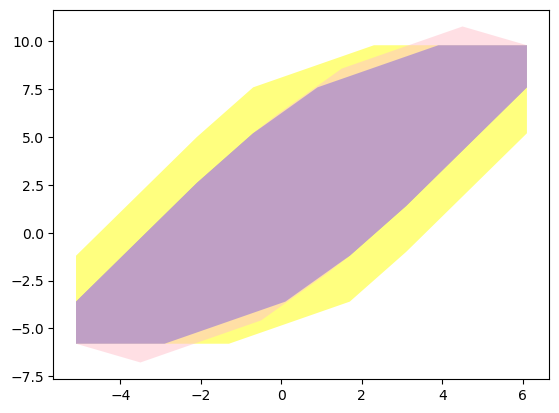

In [10]:
expr_ls = [0.5+1.5*sb('z1')+1.5*sb('z2')+1.1*sb('z4')+0.8*sb('z5')+0.7*sb('z6'),
           2+sb('z2')+1.1*sb('z1')+2.1*sb('z2')+1.1*sb('z3')+1.2*sb('z5')+1.3*sb('z6')]
nopca = merge_small_components(expr_ls, budget=3)
fig = plt.figure(0)
plot_conretiztion(nopca,color='yellow')
plot_conretiztion(expr_ls, color = 'blue')
pca = merge_small_components_pca(expr_ls, budget=5)
plot_conretiztion(list(pca),color='pink')

In [11]:
# test merging
expr_ls = [0.5+1.5*sb('z1')*sb('z1'), sb('z2')*sb('z1')*sb('z1')+1.1*sb('z1')*sb('z1')]
print(expr_ls)
print(merge_high_order_components(expr_ls))

[1.5*z1**2 + 0.5, z1**2*z2 + 1.1*z1**2]
[1.5*e4 + 0.5, 1.1*e4 + e5]


In [12]:
# test containment after merging with synthetic zonotopes
for i in tqdm(range(1000)):
    num_symbol = 6
    zonotope = zonotope_gen(num_symbol=num_symbol, seed=i)
    pts = np.array(list(map(list, get_vertices(zonotope))))
    pca = merge_small_components_pca(zonotope, budget=num_symbol//2)
    nopca = merge_small_components(zonotope, budget=num_symbol//2)
    for pt in pts:
        assert lp_zonotope_point_containment(pt, pca).success
        assert lp_zonotope_point_containment(pt, sympy.Matrix(nopca)).success

  0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'zonotope_gen' is not defined

In [13]:
symbols_in_data = set()
symbol_to_position = dict()

# convert ranges into symbolic representation 
symbol_id = -1
symbolic_data = X_extended.tolist()
for row in range(len(symbolic_data)):
    for col in range(len(symbolic_data[0])):
        xmin = X_extended_min[row][col]
        xmax = X_extended_max[row][col]
        if xmin != xmax:
            xmean = (xmax + xmin) / 2
            xradius = (xmax - xmin) / 2
            new_symbol = create_symbol()
            symbolic_data[row][col] = xmean + xradius*new_symbol
            symbols_in_data.add(new_symbol)
            symbol_to_position[new_symbol] = (row, col)

# Model training

## Closed form

In [34]:
# convert ranges into symbolic representation 
symbol_id = -1
symbolic_data = X_extended.tolist()
symbols_in_data = set()
symbol_to_position = dict()
XS = X_extended.tolist()
XR = X_extended.tolist()
for row in range(len(symbolic_data)):
    for col in range(len(symbolic_data[0])):
        xmin = X_extended_min[row][col]
        xmax = X_extended_max[row][col]
        if xmin != xmax:
            xmean = (xmax + xmin) / 2
            xradius = (xmax - xmin) / 2
            new_symbol = create_symbol()
            symbolic_data[row][col] = xmean + xradius*new_symbol
            XS[row][col] = xradius*new_symbol
            XR[row][col] = xmean
            symbols_in_data.add(new_symbol)
            symbol_to_position[new_symbol] = (row, col)
        else:
            XS[row][col] = 0
XS = sympy.Matrix(XS)
XR = sympy.Matrix(XR)

In [29]:
VT, sigma, V = np.linalg.svd(np.array((XR.T*XR).tolist()).astype(float))
V_mat = sympy.Matrix(V)
y_mat = sympy.Matrix(y)

wR = (XR.T*XR).inv()*XR.T*y_mat
wS_non_data = 0.0*V_mat.row(0).T
for i in range(len(symbolic_data[0])):
    wS_non_data = wS_non_data + sb(f'k{i}')*sb(f'ep{i}')*V_mat.row(i).T
A = V_mat.inv()*np.diag(eigenvalues)*V_mat
wS_data = (np.identity(len(symbolic_data[0]))-A).inv()*((XS.T*XR + XR.T*XS)*wR - \
                                                        XS.T*y_mat)*lamb*2/len(symbolic_data)

wS = wS_non_data + wS_data
w = wS + wR
w_prime = ((XS.T*XR + XR.T*XS + XS.T*XS)*wS + XS.T*XS*wR).expand()
w_prime_projected = V_mat*w_prime

In [30]:
eqs = []
for d in range(len(symbolic_data[0])):
    eq1 = (1-eigenvalues[d])*sb(f'k{d}')
    eq2 = 0
    coef_dict = dict()
    coef_dict['const'] = 0
    for i in range(len(symbolic_data[0])):
        coef_dict[sb(f'k{i}')] = 0
    for arg in w_prime_projected[d].args:
        contain_k = False
        for i in range(len(symbolic_data[0])):
            symb_k = sb(f'k{i}')
            if symb_k in arg.free_symbols:
                coef_dict[symb_k] = coef_dict[symb_k] + abs(arg.args[0])
                contain_k = True
        if not(contain_k):
            coef_dict['const'] = coef_dict['const'] + abs(arg.args[0])
    eq2 = coef_dict['const']
    for i in range(len(symbolic_data[0])):
        eq2 = eq2 + sb(f'k{i}')*coef_dict[sb(f'k{i}')]
    eqs.append(sympy.Eq(eq1, eq2*lamb*2/len(symbolic_data)))

In [31]:
result = sympy.solve(eqs, [sb(f'k{i}') for i in range(len(symbolic_data[0]))])

In [32]:
param = wR+wS.subs(result)

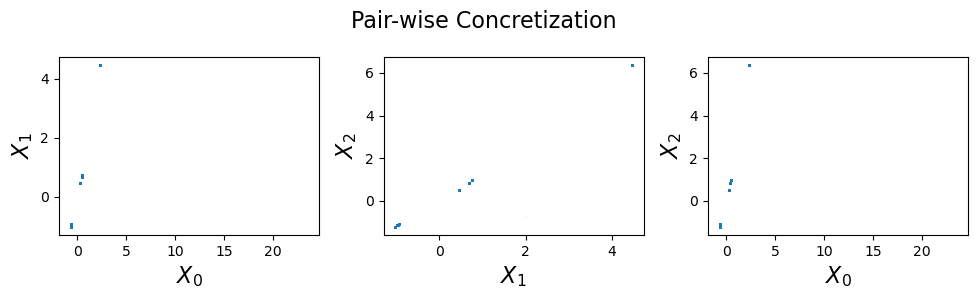

In [33]:
fig = plt.figure(figsize=(10, 3))
plt.subplot(131)
plot_conretiztion([param[0], param[1]], 0.5)
plt.scatter([sp[0] for sp in sample_params_np], [sp[1] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_0$', fontsize=16)
plt.ylabel('$X_1$', fontsize=16)
# plt.axis('equal')

plt.subplot(132)
plot_conretiztion([param[1], param[2]])
plt.scatter([sp[1] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_1$', fontsize=16)
plt.ylabel('$X_2$', fontsize=16)
# plt.axis('equal')

plt.subplot(133)
plot_conretiztion([param[0], param[2]])
plt.scatter([sp[0] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_0$', fontsize=16)
plt.ylabel('$X_2$', fontsize=16)
# plt.axis('equal')
fig.suptitle('Pair-wise Concretization', fontsize=16)
plt.tight_layout()

In [21]:
eqs = []
for d in range(len(symbolic_data[0])):
    eq1 = (1-eigenvalues[d])*sb(f'k{d}')
    eq2 = 0
    coef_dict = dict()
    coef_dict['const'] = 0
    for i in range(len(symbolic_data[0])):
        coef_dict[sb(f'k{i}')] = 0
    for arg in w_prime[d].args:
        contain_k = False
        for i in range(len(symbolic_data[0])):
            symb_k = sb(f'k{i}')
            if symb_k in arg.free_symbols:
                coef_dict[symb_k] = coef_dict[symb_k] + abs(arg.args[0])
                contain_k = True
        if not(contain_k):
            coef_dict['const'] = coef_dict['const'] + abs(arg.args[0])
    eq2 = coef_dict['const']
    for i in range(len(symbolic_data[0])):
        eq2 = eq2 + sb(f'k{i}')*coef_dict[sb(f'k{i}')]
    eqs.append(sympy.Eq(eq1, eq2*lamb*2/len(symbolic_data)))

# set of linear equations to solve (# eqs = dimension of data)
eqs

[Eq(0.919691161951702*k0, 0.000569717449818953*k0 + 0.000194817996275014*k1 + 0.000203300666197061*k2 + 0.000239702657966346*k3 + 0.000157451383671907*k4 + 0.000349329780616003*k5 + 0.000400986116068386*k6 + 0.000114983528266229*k7 + 0.000607988326470924),
 Eq(0.200023186167942*k1, 0.000194817996275014*k0 + 1.03544667201374e-5*k1 + 6.42517604304879e-5*k2 + 7.80588376043487e-5*k3 + 5.31297761180667e-5*k4 + 0.000244669412604548*k5 + 0.000266483843609634*k6 + 7.30824938019015e-5*k7 + 0.000263973383849147),
 Eq(0.188145793502935*k2, 0.000203300666197061*k0 + 6.42517604304879e-5*k1 + 8.68857590300699e-5*k2 + 7.86969518887955e-5*k3 + 5.70856386544269e-5*k4 + 0.000169758918206756*k5 + 0.000196689293835553*k6 + 5.47104436489968e-5*k7 + 0.000331783081841605),
 Eq(0.149753144244833*k3, 0.000239702657966346*k0 + 7.80588376043487e-5*k1 + 7.86969518887955e-5*k2 + 0.000151305253779282*k3 + 6.5573724927216e-5*k4 + 0.000246866117228362*k5 + 0.00026579224068619*k6 + 7.50523112757287e-5*k7 + 0.000430342

In [22]:
result = sympy.solve(eqs, [sb(f'k{i}') for i in range(len(symbolic_data[0]))])

# constructed fixed point params
wR+wS.subs(result)

Matrix([
[-8.29140493767738e-7*ep0 - 0.00147317454534595*ep1 + 4.35220773228009e-5*ep2 - 2.07021280727615e-5*ep3 + 5.70621516894815e-6*ep4 + 0.000177565262619056*ep5 - 0.000490114634737464*ep6 + 6.19442323287933e-5*ep7 + 23.5086052161902],
[   0.000323507996887622*ep0 - 6.78585896351153e-6*ep1 - 0.000199593056476293*ep2 - 7.74007661680961e-5*ep3 + 0.00041704768741274*ep4 - 0.00491078003378253*ep5 - 0.0047221233343807*ep6 - 0.0311145842759561*ep7 + 2.04665017376226],
[   0.000312625090818009*ep0 - 7.25674424829322e-6*ep1 - 0.000215838013658555*ep2 - 8.4778688052237e-5*ep3 + 0.000630479597449591*ep4 - 0.0197936638366285*ep5 - 0.0144083657578403*ep6 + 0.0165969999849503*ep7 - 0.731898895199763],
[ 0.000311050285533966*ep0 + 1.78048980988583e-5*ep1 + 0.000268929480874658*ep2 - 0.00054222581552088*ep3 + 0.000308493754588285*ep4 + 0.0161035841621484*ep5 - 0.0480676830780658*ep6 + 0.00624151584783608*ep7 - 0.622141988237465],
[  0.000308081020068668*ep0 - 9.36554821067358e-6*ep1 - 0.000383079

In [23]:
sample_mses = []
sample_params = []
for s in tqdm(range(1000), desc='Samples'):
    samp = sample_data(imputed_datasets)
    mses = []
    params = []
    w = np.zeros(len(symbolic_data[0])).reshape(1, -1)
    for i in range(2000):
        grad = (samp * (np.matmul(samp, w.T)-y.reshape(-1, 1)) * lamb).mean(axis=0)
        w = w - grad
        params.append(w[0])
        mses.append(((np.matmul(samp, w.T)-y.reshape(-1, 1))**2).mean())
    sample_mses.append(mses)
    sample_params.append(params)

sample_params_np = np.array(sample_params)
sample_mses_np = np.array(sample_mses)

Samples:   0%|          | 0/1000 [00:00<?, ?it/s]

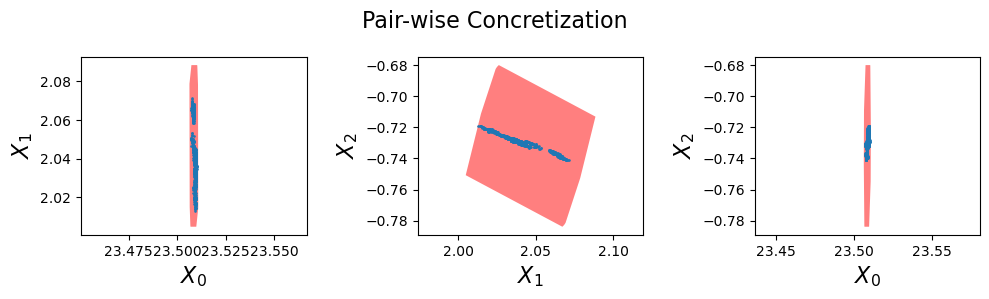

In [24]:
param = wR+wS.subs(result)

fig = plt.figure(figsize=(10, 3))
plt.subplot(131)
plot_conretiztion([param[0], param[1]], 0.5)
plt.scatter([sp[-1][0] for sp in sample_params_np], [sp[-1][1] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_0$', fontsize=16)
plt.ylabel('$X_1$', fontsize=16)
plt.axis('equal')

plt.subplot(132)
plot_conretiztion([param[1], param[2]])
plt.scatter([sp[-1][1] for sp in sample_params_np], [sp[-1][2] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_1$', fontsize=16)
plt.ylabel('$X_2$', fontsize=16)
plt.axis('equal')

plt.subplot(133)
plot_conretiztion([param[0], param[2]])
plt.scatter([sp[-1][0] for sp in sample_params_np], [sp[-1][2] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_0$', fontsize=16)
plt.ylabel('$X_2$', fontsize=16)
plt.axis('equal')
fig.suptitle('Pair-wise Concretization', fontsize=16)
plt.tight_layout()

Text(0, 0.5, '$X_7$')

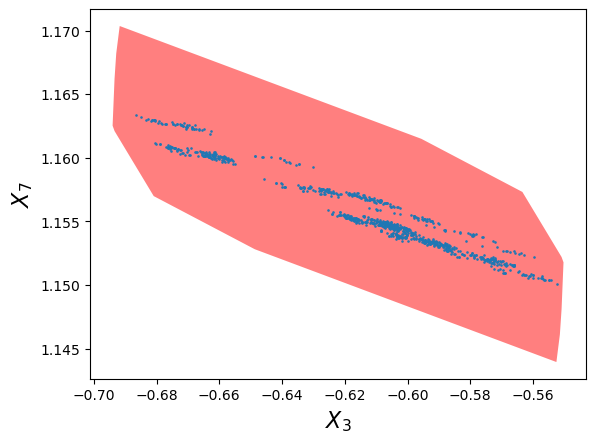

In [25]:
plot_conretiztion([param[3], param[7]], 0.5)
plt.scatter([sp[-1][3] for sp in sample_params_np], [sp[-1][7] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_3$', fontsize=16)
plt.ylabel('$X_7$', fontsize=16)

## split

In [33]:
# expr can be a expression, or an array/vector or matrix in sympy
def split_expr(expr, symbol, split_percent=[0, 0.5, 1], verbose=False):
    splits = []
    for split_id in range(len(split_percent)-1):
        radius = 2 / (len(split_percent)-1) / 2
        lb, ub = split_percent[split_id]*2-1, split_percent[split_id+1]*2-1
        center = (lb + ub) / 2
        splits.append(copy.deepcopy(expr.subs([(symbol, symbol*radius+center)]).expand()))
    return splits

# take a list of sympy expression as input, output the symbol to split
# currently only choose a variable based on the heuristic 
def heuristic_based_choice(expr_ls):
    monomials = dict()
    for expr in expr_ls:
        p = sympy.Poly(expr)
        monomials_in_expr = [sympy.prod(x**k for x, k in zip(p.gens, mon)) 
                             for mon in p.monoms() if sum(mon) > 1]
        for monomial in monomials_in_expr:
            coef = float(p.coeff_monomial(monomial))
            if monomial in monomials:
                monomials[monomial].append(coef)
            else:
                monomials[monomial] = [coef]
    symbol_heuristic_vals = dict([(symb, 0) for symb in symbols_in_data])
    for monomial, monomial_coefs in monomials.items():
        monomial_norm = np.linalg.norm(monomial_coefs)
        for symb in symbols_in_data.intersection(monomial.free_symbols):
            symbol_heuristic_vals[symb] += monomial_norm
    symb_to_split = sorted(list(symbol_heuristic_vals.items()), reverse=True, key=lambda x: x[1])[0][0]
    print(symbol_heuristic_vals)
    return symb_to_split

# input a list of data, return a list that contains all splits of all data in the input list
def split_data(data_ls, symbol):
    assert symbol in symbols_in_data
    output_splits = []
    for data in data_ls:
        row, col = symbol_to_position[symbol]
        expr_to_split = data[row][col]
        expr_splits = split_expr(expr_to_split, symbol)
        for expr_split in expr_splits:
            data_split = copy.deepcopy(data)
            data_split[row][col] = expr_split
            output_splits.append(data_split)
    return output_splits

In [240]:
X_pd[X_pd.horsepower.isna()]

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
32,98.0,4,NaN,2046,19.0,71,1
126,200.0,6,NaN,2875,17.0,74,1
330,85.0,4,NaN,1835,17.3,80,2
336,140.0,4,NaN,2905,14.3,80,1
354,100.0,4,NaN,2320,15.8,81,2
374,151.0,4,NaN,3035,20.5,82,1


In [360]:
N = 75
val_epoch = 5
lamb = 0.1
data_splits = split_data([symbolic_data], sb('e0'))
splits_loss_quantiles = []
splits_params = []
for symbolic_data_split in data_splits:
    params = []
    loss_quantiles = []
    param = [0.0 for _ in range(num_attrs)]

    for iteration in tqdm.tqdm(range(N)):
        preds = [sum([param[j]*symbolic_data_split[i][j] for j in range(len(param))])
                 for i in range(len(symbolic_data_split))]
        grad_component_1 = [preds[i] - y[i] for i in range(len(symbolic_data_split))]
        grad_component_2 = symbolic_data_split
        grad = [sum([grad_component_2[i][j]*grad_component_1[i] for i in range(len(symbolic_data_split))]) for j in range(len(param))]
        grad = [merge_high_order_components(merge_small_components(g)) for g in grad]
        param = merge_independent_terms([param[j] - grad[j]*lamb/len(symbolic_data_split) for j in range(len(param))], symbols_in_data)

        # record mse ranges
        if ((iteration + 1) % val_epoch == 0):
            preds = [sum([param[j]*symbolic_data_split[i][j] for j in range(len(param))]) for i in range(len(symbolic_data_split))]
            mse = sum([merge_small_components((preds[i] - y[i])**2) for i in range(len(symbolic_data_split))])
            max_expr, min_expr = 0, 0
            subexprs = dict()
            for arg in mse.args:
                if arg.free_symbols:
                    assert len(arg.free_symbols) == 1
                    symbol = list(arg.free_symbols)[0]
                    if symbol in subexprs:
                        subexprs[symbol] += arg
                    else:
                        subexprs[symbol] = arg
                else:
                    max_expr += arg
                    min_expr += arg
            for symbol in subexprs:
                pos_func = lambdify([symbol], subexprs[symbol])
                res = scipy_min(pos_func, 1.0, bounds=Bounds(-1, 1))
                min_expr += res.fun

                neg_func = lambdify([symbol], -subexprs[symbol])
                res = scipy_min(neg_func, 1.0, bounds=Bounds(-1, 1))
                max_expr += -res.fun
            loss_quantiles.append([min_expr/len(symbolic_data_split), max_expr/len(symbolic_data_split)])
        params.append(param)
    splits_loss_quantiles.append(loss_quantiles)
    splits_params.append(params)

100%|██████████| 75/75 [34:32<00:00, 27.64s/it]


In [367]:
encoded_params = pickle.dumps(splits_params)
with open('2_split', 'wb') as f:
    f.write(encoded_params)

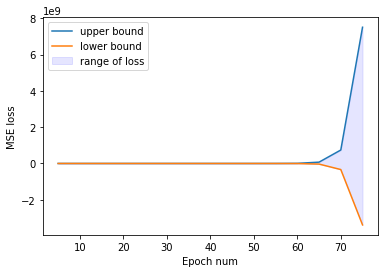

In [362]:
# bound convergence plots
loss_quantiles = splits_loss_quantiles[0]
loss_bounds = np.array(loss_quantiles).astype(float)
fig, ax = plt.subplots()
ax.plot([val_epoch*i for i in range(1, int(N//val_epoch)+1)], loss_bounds[:, 1], label='upper bound')
ax.plot([val_epoch*i for i in range(1, int(N//val_epoch)+1)], loss_bounds[:, 0], label='lower bound')
ax.fill_between([val_epoch*i for i in range(1, int(N//val_epoch)+1)], 
                loss_bounds[:, 0], loss_bounds[:, 1],
                color='b', alpha=.1, label='range of loss')
plt.legend()
plt.xlabel('Epoch num')
plt.ylabel('MSE loss')

plt.show()

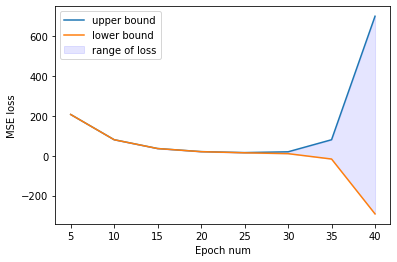

In [363]:
# bound convergence plots
mid = 8
loss_bounds = np.array(loss_quantiles).astype(float)
fig, ax = plt.subplots()
ax.plot([val_epoch*i for i in range(1, int(N//val_epoch)+1)][:mid], loss_bounds[:, 1][:mid], label='upper bound')
ax.plot([val_epoch*i for i in range(1, int(N//val_epoch)+1)][:mid], loss_bounds[:, 0][:mid], label='lower bound')
ax.fill_between([val_epoch*i for i in range(1, int(N//val_epoch)+1)][:mid], 
                loss_bounds[:, 0][:mid], loss_bounds[:, 1][:mid],
                color='b', alpha=.1, label='range of loss')
plt.legend()
plt.xlabel('Epoch num')
plt.ylabel('MSE loss')

plt.show()

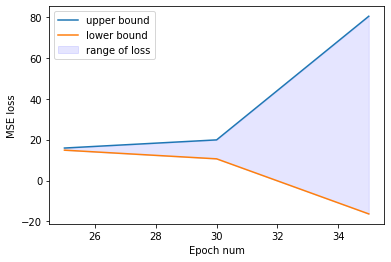

In [364]:
# bound convergence plots
prev = 4
mid = 7
loss_bounds = np.array(loss_quantiles).astype(float)
fig, ax = plt.subplots()
ax.plot([val_epoch*i for i in range(1, int(N//val_epoch)+1)][prev:mid], 
        loss_bounds[:, 1][prev:mid], label='upper bound')
ax.plot([val_epoch*i for i in range(1, int(N//val_epoch)+1)][prev:mid], 
        loss_bounds[:, 0][prev:mid], label='lower bound')
ax.fill_between([val_epoch*i for i in range(1, int(N//val_epoch)+1)][prev:mid], 
                loss_bounds[:, 0][prev:mid], loss_bounds[:, 1][prev:mid],
                color='b', alpha=.1, label='range of loss')
plt.legend()
plt.xlabel('Epoch num')
plt.ylabel('MSE loss')

plt.show()

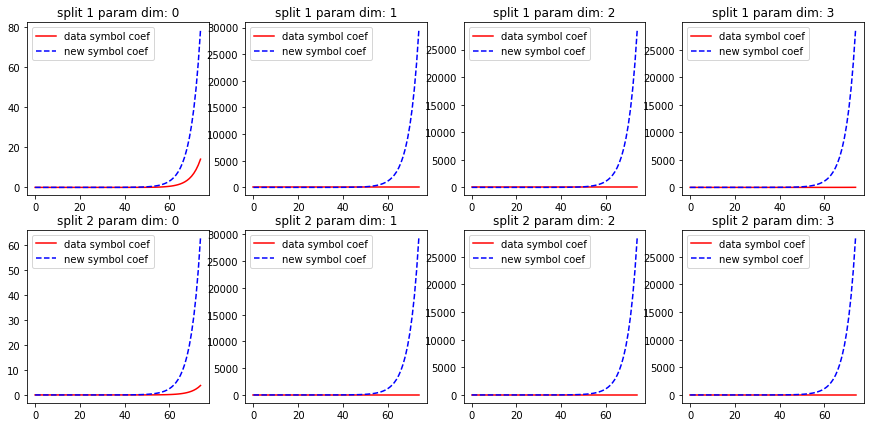

In [366]:
with open('2_split', 'rb') as f:
    split_params = pickle.load(f)

plt.figure(figsize=(15, 7))
for param_dim in range(4):
    plt.subplot(2, 4, param_dim+1)
    params = split_params[0]
    data_symb_coef_sum_ls = []
    new_symb_coef_sum_ls = []
    for e in range(len(params)):
        curr_param = params[e][param_dim]
        data_symb_coef_sum = 0
        new_symb_coef_sum = 0
        for arg in curr_param.args:
            if arg.free_symbols:
                assert len(arg.free_symbols) == 1
                symbol = list(arg.free_symbols)[0]
                coef = abs(arg.coeff(symbol))
                if symbol in symbols_in_data:
                    data_symb_coef_sum += coef
                else:
                    new_symb_coef_sum += coef
        data_symb_coef_sum_ls.append(data_symb_coef_sum)
        new_symb_coef_sum_ls.append(new_symb_coef_sum)

    plt.plot(range(len(params)), data_symb_coef_sum_ls, '-r', label='data symbol coef')
    plt.plot(range(len(params)), new_symb_coef_sum_ls, '--b', label='new symbol coef')
    plt.legend()
    plt.title(f'split 1 param dim: {param_dim}')

for param_dim in range(4):
    plt.subplot(2, 4, param_dim+5)
    params = split_params[1]
    data_symb_coef_sum_ls = []
    new_symb_coef_sum_ls = []
    for e in range(len(params)):
        curr_param = params[e][param_dim]
        data_symb_coef_sum = 0
        new_symb_coef_sum = 0
        for arg in curr_param.args:
            if arg.free_symbols:
                assert len(arg.free_symbols) == 1
                symbol = list(arg.free_symbols)[0]
                coef = abs(arg.coeff(symbol))
                if symbol in symbols_in_data:
                    data_symb_coef_sum += coef
                else:
                    new_symb_coef_sum += coef
        data_symb_coef_sum_ls.append(data_symb_coef_sum)
        new_symb_coef_sum_ls.append(new_symb_coef_sum)

    plt.plot(range(len(params)), data_symb_coef_sum_ls, '-r', label='data symbol coef')
    plt.plot(range(len(params)), new_symb_coef_sum_ls, '--b', label='new symbol coef')
    plt.legend()
    plt.title(f'split 2 param dim: {param_dim}')

## more splits

In [378]:
N = 75
val_epoch = 5
lamb = 0.1
data_splits = split_data(split_data(split_data([symbolic_data], sb('e0')), sb('e2')), sb('e5'))
splits_loss_quantiles = []
splits_params = []
for symbolic_data_split in data_splits:
    params = []
    loss_quantiles = []
    param = [0.0 for _ in range(num_attrs)]

    for iteration in tqdm.tqdm(range(N)):
        preds = [sum([param[j]*symbolic_data_split[i][j] for j in range(len(param))])
                 for i in range(len(symbolic_data_split))]
        grad_component_1 = [preds[i] - y[i] for i in range(len(symbolic_data_split))]
        grad_component_2 = symbolic_data_split
        grad = [sum([grad_component_2[i][j]*grad_component_1[i] for i in range(len(symbolic_data_split))]) for j in range(len(param))]
        grad = [merge_high_order_components(merge_small_components(g)) for g in grad]
        param = merge_independent_terms([param[j] - grad[j]*lamb/len(symbolic_data_split) for j in range(len(param))], symbols_in_data)

        # record mse ranges
        if ((iteration + 1) % val_epoch == 0):
            preds = [sum([param[j]*symbolic_data_split[i][j] for j in range(len(param))]) for i in range(len(symbolic_data_split))]
            mse = sum([merge_small_components((preds[i] - y[i])**2) for i in range(len(symbolic_data_split))])
            max_expr, min_expr = 0, 0
            subexprs = dict()
            for arg in mse.args:
                if arg.free_symbols:
                    assert len(arg.free_symbols) == 1
                    symbol = list(arg.free_symbols)[0]
                    if symbol in subexprs:
                        subexprs[symbol] += arg
                    else:
                        subexprs[symbol] = arg
                else:
                    max_expr += arg
                    min_expr += arg
            for symbol in subexprs:
                pos_func = lambdify([symbol], subexprs[symbol])
                res = scipy_min(pos_func, 1.0, bounds=Bounds(-1, 1))
                min_expr += res.fun

                neg_func = lambdify([symbol], -subexprs[symbol])
                res = scipy_min(neg_func, 1.0, bounds=Bounds(-1, 1))
                max_expr += -res.fun
            loss_quantiles.append([min_expr/len(symbolic_data_split), max_expr/len(symbolic_data_split)])
        params.append(param)
    splits_loss_quantiles.append(loss_quantiles)
    splits_params.append(params)

100%|██████████| 75/75 [34:33<00:00, 27.65s/it]


In [379]:
encoded_params = pickle.dumps(splits_params)
with open('8_split', 'wb') as f:
    f.write(encoded_params)

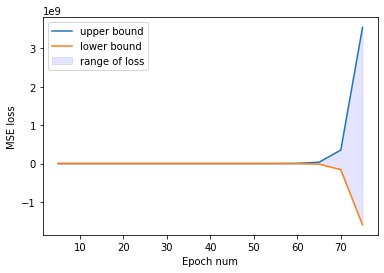

In [380]:
# bound convergence plots
loss_quantiles = splits_loss_quantiles[0]
loss_bounds = np.array(loss_quantiles).astype(float)
fig, ax = plt.subplots()
ax.plot([val_epoch*i for i in range(1, int(N//val_epoch)+1)], loss_bounds[:, 1], label='upper bound')
ax.plot([val_epoch*i for i in range(1, int(N//val_epoch)+1)], loss_bounds[:, 0], label='lower bound')
ax.fill_between([val_epoch*i for i in range(1, int(N//val_epoch)+1)], 
                loss_bounds[:, 0], loss_bounds[:, 1],
                color='b', alpha=.1, label='range of loss')
plt.legend()
plt.xlabel('Epoch num')
plt.ylabel('MSE loss')

plt.show()

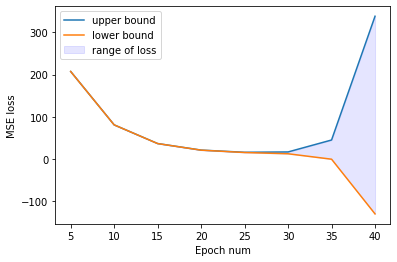

In [381]:
# bound convergence plots
mid = 8
loss_bounds = np.array(loss_quantiles).astype(float)
fig, ax = plt.subplots()
ax.plot([val_epoch*i for i in range(1, int(N//val_epoch)+1)][:mid], loss_bounds[:, 1][:mid], label='upper bound')
ax.plot([val_epoch*i for i in range(1, int(N//val_epoch)+1)][:mid], loss_bounds[:, 0][:mid], label='lower bound')
ax.fill_between([val_epoch*i for i in range(1, int(N//val_epoch)+1)][:mid], 
                loss_bounds[:, 0][:mid], loss_bounds[:, 1][:mid],
                color='b', alpha=.1, label='range of loss')
plt.legend()
plt.xlabel('Epoch num')
plt.ylabel('MSE loss')

plt.show()

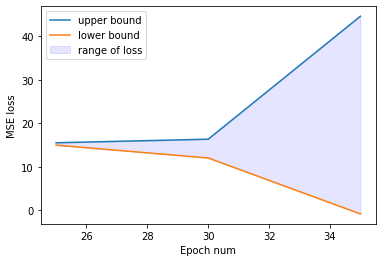

In [382]:
# bound convergence plots
prev = 4
mid = 7
loss_bounds = np.array(loss_quantiles).astype(float)
fig, ax = plt.subplots()
ax.plot([val_epoch*i for i in range(1, int(N//val_epoch)+1)][prev:mid], 
        loss_bounds[:, 1][prev:mid], label='upper bound')
ax.plot([val_epoch*i for i in range(1, int(N//val_epoch)+1)][prev:mid], 
        loss_bounds[:, 0][prev:mid], label='lower bound')
ax.fill_between([val_epoch*i for i in range(1, int(N//val_epoch)+1)][prev:mid], 
                loss_bounds[:, 0][prev:mid], loss_bounds[:, 1][prev:mid],
                color='b', alpha=.1, label='range of loss')
plt.legend()
plt.xlabel('Epoch num')
plt.ylabel('MSE loss')

plt.show()

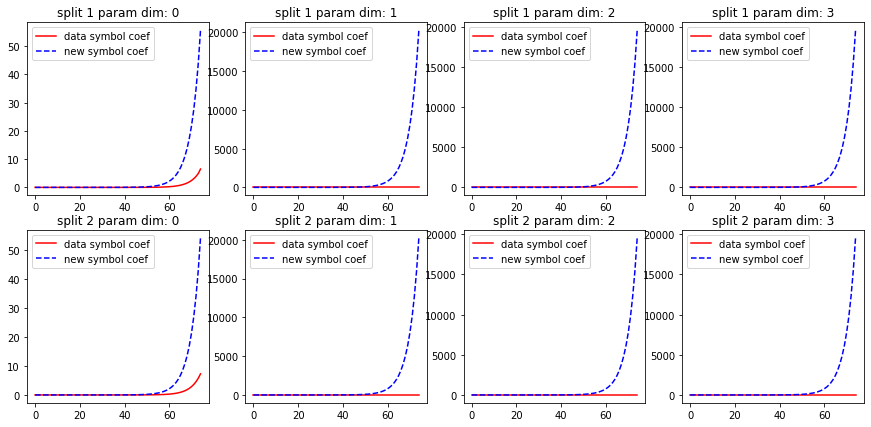

In [384]:
with open('8_split', 'rb') as f:
    split_params = pickle.load(f)

plt.figure(figsize=(15, 7))
for param_dim in range(4):
    plt.subplot(2, 4, param_dim+1)
    params = split_params[0]
    data_symb_coef_sum_ls = []
    new_symb_coef_sum_ls = []
    for e in range(len(params)):
        curr_param = params[e][param_dim]
        data_symb_coef_sum = 0
        new_symb_coef_sum = 0
        for arg in curr_param.args:
            if arg.free_symbols:
                assert len(arg.free_symbols) == 1
                symbol = list(arg.free_symbols)[0]
                coef = abs(arg.coeff(symbol))
                if symbol in symbols_in_data:
                    data_symb_coef_sum += coef
                else:
                    new_symb_coef_sum += coef
        data_symb_coef_sum_ls.append(data_symb_coef_sum)
        new_symb_coef_sum_ls.append(new_symb_coef_sum)

    plt.plot(range(len(params)), data_symb_coef_sum_ls, '-r', label='data symbol coef')
    plt.plot(range(len(params)), new_symb_coef_sum_ls, '--b', label='new symbol coef')
    plt.legend()
    plt.title(f'split 1 param dim: {param_dim}')

for param_dim in range(4):
    plt.subplot(2, 4, param_dim+5)
    params = split_params[1]
    data_symb_coef_sum_ls = []
    new_symb_coef_sum_ls = []
    for e in range(len(params)):
        curr_param = params[e][param_dim]
        data_symb_coef_sum = 0
        new_symb_coef_sum = 0
        for arg in curr_param.args:
            if arg.free_symbols:
                assert len(arg.free_symbols) == 1
                symbol = list(arg.free_symbols)[0]
                coef = abs(arg.coeff(symbol))
                if symbol in symbols_in_data:
                    data_symb_coef_sum += coef
                else:
                    new_symb_coef_sum += coef
        data_symb_coef_sum_ls.append(data_symb_coef_sum)
        new_symb_coef_sum_ls.append(new_symb_coef_sum)

    plt.plot(range(len(params)), data_symb_coef_sum_ls, '-r', label='data symbol coef')
    plt.plot(range(len(params)), new_symb_coef_sum_ls, '--b', label='new symbol coef')
    plt.legend()
    plt.title(f'split 2 param dim: {param_dim}')

## leave one symbol (e5)

In [437]:
params, loss_quantiles = train_model(symbolic_data[350:], y[350:], N=200, 
                                     val_epoch=10, lamb=0.3, num_attrs=4, merge_budget=20)

  0%|          | 0/200 [00:00<?, ?it/s]

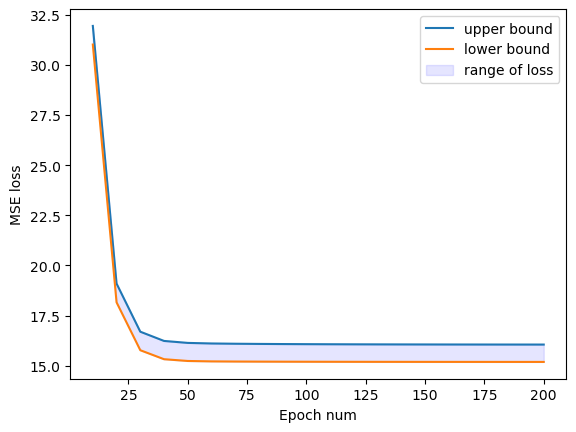

In [440]:
# # bound convergence plots
# loss_bounds = np.array(loss_quantiles).astype(float)
# fig, ax = plt.subplots()
# ax.plot([val_epoch*i for i in range(1, int(N//val_epoch)+1)], loss_bounds[:, 1], label='upper bound')
# ax.plot([val_epoch*i for i in range(1, int(N//val_epoch)+1)], loss_bounds[:, 0], label='lower bound')
# ax.fill_between([val_epoch*i for i in range(1, int(N//val_epoch)+1)], 
#                 loss_bounds[:, 0], loss_bounds[:, 1],
#                 color='b', alpha=.1, label='range of loss')
# plt.legend()
# plt.xlabel('Epoch num')
# plt.ylabel('MSE loss')

# plt.show()
plot_mse(loss_quantiles, 10)

In [36]:
# train_model(symbolic_data, y, N = 75, val_epoch = 5, lamb = 0.1, num_attrs = 6)
#             -> params,loss_quantiles
num_attrs = 8
symbolic_data_split = copy.deepcopy(symbolic_data)
symbolic_data_split = [tup[:num_attrs] for tup in symbolic_data_split]
y_sample = copy.deepcopy(y)
val_epoch = 10
params,loss_quantiles = train_model(symbolic_data_split, y_sample, N=1000, val_epoch=val_epoch, num_attrs=num_attrs,merge_budget=20)
param = params[-1]

Trainning: 
 data size = 398 
 N = 1000 
 nattrs = 8 
 merge_budget = 20


  0%|          | 0/1000 [00:00<?, ?it/s]

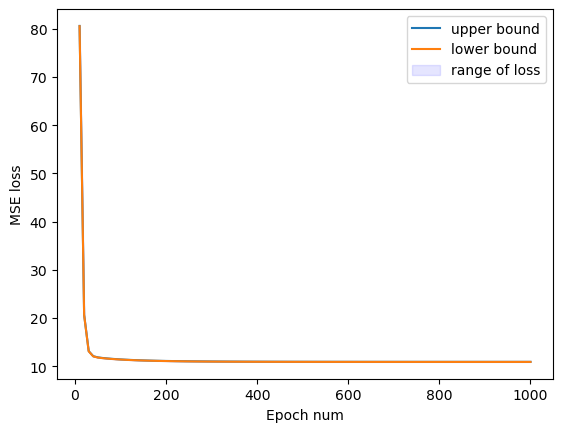

[[23.5055442978336, 23.5119320387185], [1.89605453316805, 1.99799538518418], [-0.709291257127799, -0.652663249648384], [-0.688767683397599, -0.528379503068441], [-5.61910438083591, -5.50699371355900], [0.187252638665301, 0.248663852923921], [2.76605238287849, 2.78837912953058], [1.13551555377867, 1.16367164095923]]


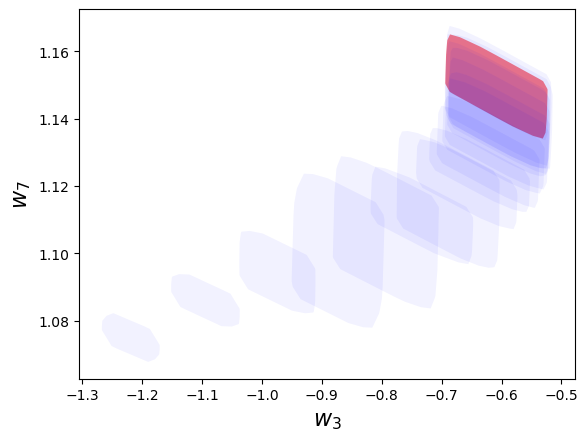

In [54]:
plot_mse(loss_quantiles, val_epoch)
# print_colored_list(loss_quantiles,100)
print([to_interval(ps) for ps in param])
plot_param_time_lapse(params,100,1000,50,3,7)

Trainning: 
 data size = 398 
 N = 1000 
 nattrs = 8 
 merge_budget = 20


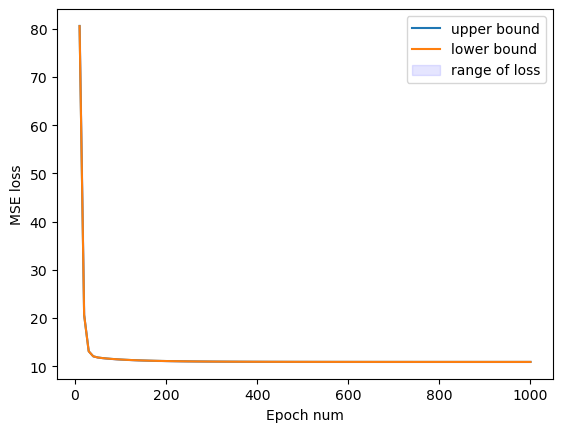

  0%|          | 0/1000 [00:00<?, ?it/s]

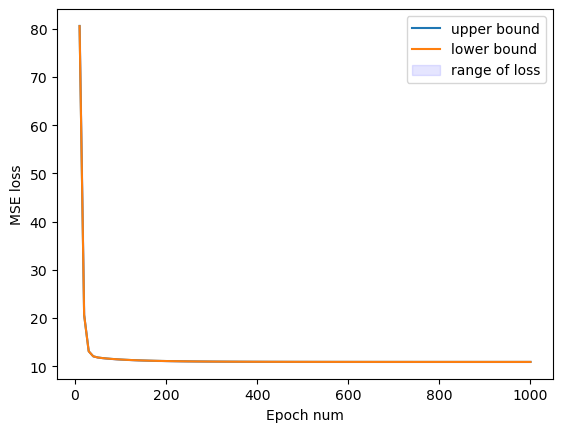

In [50]:
only_symbol_in_data = new_symbol
symbol_positions = set()

# convert ranges into symbolic representation 
symbol_id = -1
symbolic_data_one = X_extended.tolist()
for row in range(len(symbolic_data_one)):
    for col in range(len(symbolic_data_one[0])):
        xmin = X_extended_min[row][col]
        xmax = X_extended_max[row][col]
        if xmin != xmax:
            xmean = (xmax + xmin) / 2
            xradius = (xmax - xmin) / 2
            symbolic_data_one[row][col] = xmean + xradius*new_symbol
            symbol_positions.add((row, col))

params_new, loss_quantiles_new = train_model(symbolic_data_one, y, N=1000, 
                                             val_epoch=10, num_attrs=8, merge_budget=20, plot_mse = True)

[[23.5073076182084, 23.5101687183437], [1.93991961621525, 1.95413030213697], [-0.682140412389670, -0.679814094386512], [-0.624881277187089, -0.592265909278951], [-5.57136977465300, -5.55472831974191], [0.212186719778042, 0.223729771811181], [2.77593790876859, 2.77849360364048], [1.14649370380867, 1.15269349092923]]


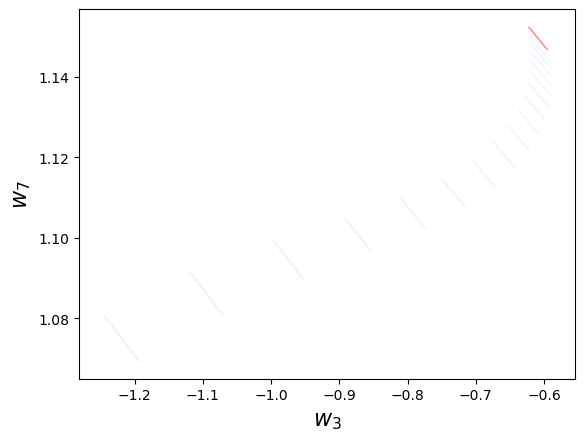

In [53]:
print([to_interval(ps) for ps in params_new[-1]])
plot_param_time_lapse(params_new,100,1000,50,3,7)

Trainning: 
 data size = 48 
 N = 100 
 nattrs = 4 
 merge_budget = 10


  0%|          | 0/100 [00:00<?, ?it/s]

[[25.1630521567627, 25.3102693260912],
 [-2.61656629013327, -2.22512486111215],
 [0.205921494313297, 0.290603775189048],
 [-7.98561285422130, -7.31220989339136]]

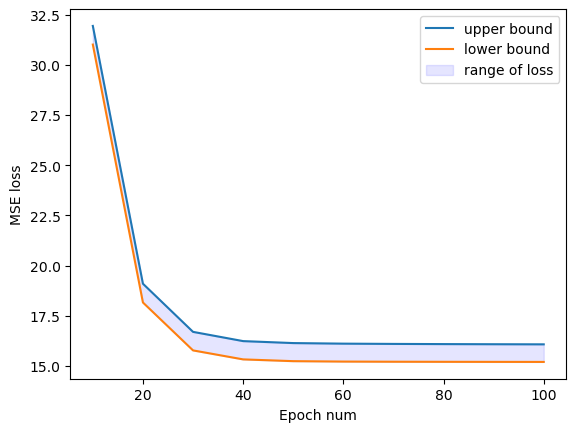

In [112]:
params, loss_quantiles = train_model(symbolic_data[350:], y[350:], N=100, 
                                     val_epoch=10, lamb=0.3, num_attrs=4, merge_budget=10, plot_mse=True)

## More Uncertainty

In [27]:
# add more null values into horsepower
null_num = 14
null_indices = np.random.choice(list(set(range(len(X_extended)))-set([symbol_to_position[s] for s in symbols_in_data])), null_num, replace=False)
X_extended_more_null = X_extended.copy()
X_extended_more_null[null_indices, 2] = np.nan

imputed_datasets = []
for imp in imputers:
    imputed_datasets.append(imp.fit_transform(X_extended_more_null))

X_extended_more_null_max = np.array(imputed_datasets).max(axis=0)
X_extended_more_null_min = np.array(imputed_datasets).min(axis=0)

In [28]:
symbols_in_data = set()
symbol_to_position = dict()

# convert ranges into symbolic representation 
symbol_id = -1
symbolic_data = X_extended_more_null.tolist()
for row in range(len(symbolic_data)):
    for col in range(len(symbolic_data[0])):
        xmin = X_extended_more_null_min[row][col]
        xmax = X_extended_more_null_max[row][col]
        if xmin != xmax:
            xmean = (xmax + xmin) / 2
            xradius = (xmax - xmin) / 2
            new_symbol = create_symbol()
            symbolic_data[row][col] = xmean + xradius*new_symbol
            symbols_in_data.add(new_symbol)
            symbol_to_position[new_symbol] = (row, col)

Trainning: 
 data size = 398 
 N = 300 
 lamb = 0.1 
 nattrs = 8 
 merge_budget = 11


Samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Symbolic:   0%|          | 0/300 [00:00<?, ?it/s]

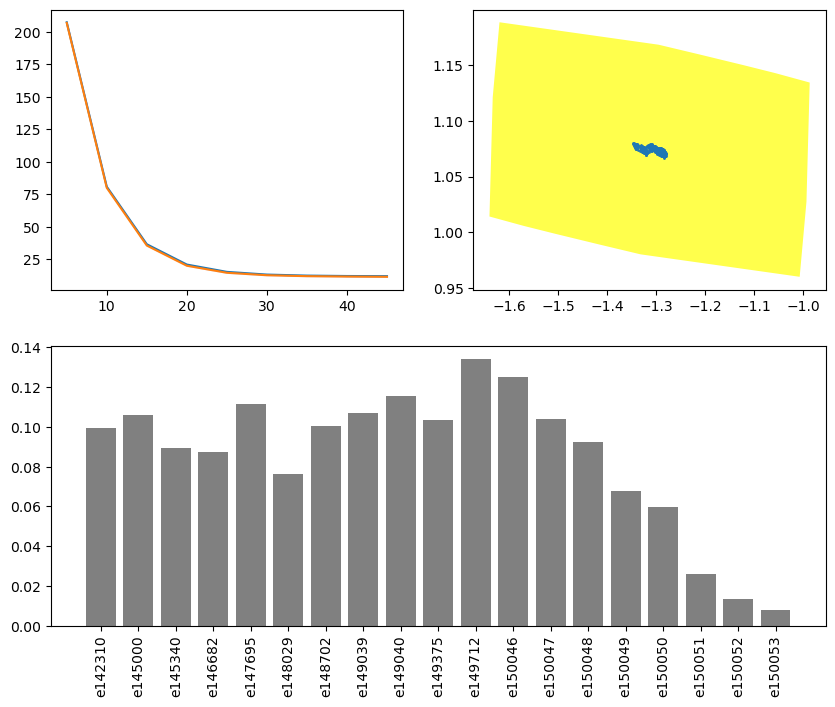

19
19
19
19
19
19
19
19
19


KeyboardInterrupt: 

<Figure size 1000x400 with 0 Axes>

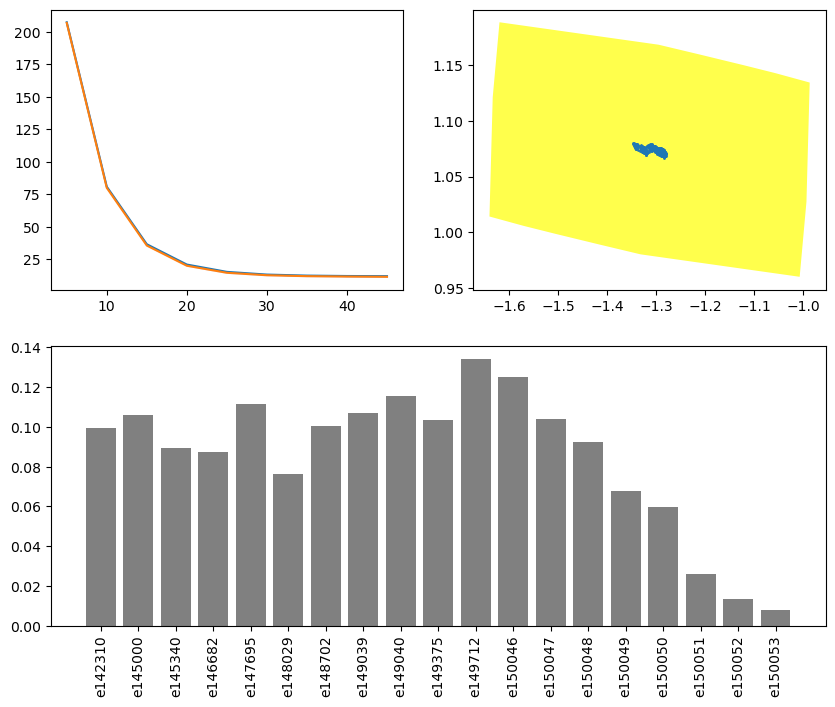

In [66]:
# imputed_datasets_small = [dt[350:] for dt in imputed_datasets]
new_params, new_loss_quantiles, sample_params, sample_mses = train_model(symbolic_data, y, N=300, val_epoch=5, lamb=0.1, 
                                             num_attrs=8, merge_budget=11, plot_mse=True, imputed_datasets = imputed_datasets, plot_stats = True)
# new_params, new_loss_quantiles, sample_params, sample_mses = train_model(symbolic_data, y, N=400, val_epoch=10, lamb=0.5, 
                                             # num_attrs=8, merge_budget=12, plot_mse=True, imputed_datasets = imputed_datasets)

## more dimensions

In [20]:
null_num = 14
null_indices = np.random.choice(list(set(range(len(X_extended)))-set([symbol_to_position[s] for s in symbols_in_data])), null_num, replace=False)
more_col = X_extended[:, [4, 5, 6]]
X_extended_more_null = np.hstack((X_extended.copy(),more_col))
X_extended_more_null[null_indices, 2] = np.nan

imputed_datasets = []
for imp in imputers:
    imputed_datasets.append(imp.fit_transform(X_extended_more_null))

X_extended_more_null_max = np.array(imputed_datasets).max(axis=0)
X_extended_more_null_min = np.array(imputed_datasets).min(axis=0)

In [21]:
symbols_in_data = set()
symbol_to_position = dict()

# convert ranges into symbolic representation 
symbol_id = -1
symbolic_data = X_extended_more_null.tolist()
for row in range(len(symbolic_data)):
    for col in range(len(symbolic_data[0])):
        xmin = X_extended_more_null_min[row][col]
        xmax = X_extended_more_null_max[row][col]
        if xmin != xmax:
            xmean = (xmax + xmin) / 2
            xradius = (xmax - xmin) / 2
            new_symbol = create_symbol()
            symbolic_data[row][col] = xmean + xradius*new_symbol
            symbols_in_data.add(new_symbol)
            symbol_to_position[new_symbol] = (row, col)

In [46]:
new_params, new_loss_quantiles, sample_params, sample_mses = train_model(symbolic_data, y, N=400, val_epoch=10, lamb=0.1, 
                                             num_attrs=11, merge_budget=12, plot_mse=True, imputed_datasets = imputed_datasets)

FileExistsError: [Errno 17] File exists: '/Users/sufeng/git/ML_AUDB/symbolic/figs/398_11_0.1_12'

## one possible world

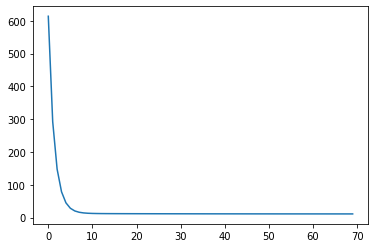

In [220]:
lamb = 0.3
mses = []

w = np.zeros(num_attrs).reshape(1, -1)
for i in range(N):
    # still compute mse on original clean data instead of sampled dirty data
    mses.append(((np.matmul(X_extended_min, w.T)-y.reshape(-1, 1))**2).mean())
    grad = (X_extended_min * (np.matmul(X_extended_min, w.T)-y.reshape(-1, 1)) * lamb).mean(axis=0)
    w = w - grad

plt.plot(range(len(mses)), mses)

In [533]:
mses[-1]

11.064285978442092